In [ ]:
import datascrape as ds
from datetime import date

In [ ]:
print(ds.munis)

<img src="images/municipalities.png">

In [ ]:
# get data of munis from 1960
for muni in ds.munis:
    print(muni)
    ds.fetch_data(muni, date(1960, 1, 1), date(2015, 12, 31))

In [ ]:
df = ds.fetch_data("KBOS", date(1960, 1, 1), date(2014, 12, 31))
# print(len(df.index))
# print(df.index)

In [ ]:
len(df[" Events"].unique())

In [ ]:
len(df)

In [ ]:
# returns dictionary of df's of municipalities with the intersection of available dates
dd = ds.dictdf(ds.munis, date(1973, 1, 1), date(1973, 4, 1))

In [ ]:
for muni, df in dd.items():
    print(len(df))

In [ ]:
print(dd["KORH"].index)

In [ ]:
dd = ds.dictdf(ds.munis, date(1960, 1, 1), date(2015, 12, 31))

In [ ]:
for muni, df in dd.items():
    print(muni, len(df))

In [ ]:
df.isnull().sum()

In [ ]:
df.columns

In [ ]:
len(df[df.index != '1968-9-14'])

### Start HMM

- 2nd order HMM
- period of data collection -- Jan 1 1960 to Dec 31 2000
    
Outputs - 
- Period of prediction 2015 - day to day
- Period of prediction - major events - decade of 2000
- Hurricane Sandy, Boston Winter of 2014

In [444]:
# imports
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
import math
import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

import string

In [445]:
# Extract data
df = ds.fetch_data("KBOS", date(1960, 1, 1), date(2010, 12, 31))

In [446]:
# Substitute nans with "noinfo" in the Events field
def replace_NaNs(df):
    for i in range(len(df)):
        if isinstance(df.iloc[i][" Events"], float):
            if math.isnan(df.iloc[i][" Events"]):
                df.set_value(df.iloc[i].name, " Events", "noinfo") 

In [447]:
# Data cleanup
# drop the one row with all NaNs in the data - '1968-9-14'
df = df[df.index != '1968-9-14']
# impute values for the few other NaNs we care about
df.set_value("2000-8-22", "Mean TemperatureF", 73) 
df.set_value("2000-6-9", "Mean TemperatureF", 75)
df.set_value("1972-8-11", " Max VisibilityMiles", 17.5)
df.set_value("1972-8-11", " Mean VisibilityMiles", 16)
df.set_value("1972-8-11", " Min VisibilityMiles", 12.5)
# Substitute nans with "noinfo" in the Events field
replace_NaNs(df)

In [448]:
list(df[" Events"].unique())

['noinfo',
 'Fog-Rain',
 'Snow',
 'Fog-Snow',
 'Fog',
 'Rain-Snow',
 'Fog-Rain-Snow',
 'Rain',
 'Fog-Rain-Thunderstorm',
 'Fog-Rain-Snow-Thunderstorm',
 'Rain-Thunderstorm',
 'Rain-Snow-Thunderstorm',
 'Fog-Snow-Thunderstorm',
 'Thunderstorm',
 'Fog-Thunderstorm',
 'Fog-Rain-Snow-Hail-Thunderstorm',
 'Fog-Rain-Hail-Thunderstorm',
 'Tornado',
 'Rain-Hail-Thunderstorm']

In [449]:
# Globals
no_distinct_events = 9 #len(df[" Events"].unique()) (suppressing all thunderstorm events into one)
event_list = list(df[" Events"].unique())
params = ['Mean TemperatureF',
          'MeanDew PointF',
          ' Mean Humidity',
          ' Mean Sea Level PressureIn',
          ' Mean VisibilityMiles',
          ' Mean Wind SpeedMPH',
          'PrecipitationIn']
no_emission_params = len(params)

In [450]:
# Helper functions
# collapsing all thunderstorm events into one thunderstorm event bucket; (1 tornado day also included)
def convert_event_to_int(event):
    idx = event_list.index(event)
    if idx > 7:
        return 8
    else:
        return idx

def convert_int_to_event(intt):
    if intt < 8:
        return event_list[intt]
    else:
        return "Thunderstorm"

def normalize(matrix):
    for i in range(matrix.shape[0]):
        matrix[i] = matrix[i]/float(sum(matrix[i]))
    return matrix

def normalize_3d(matrix):
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            matrix[i, j] = matrix[i, j]/float(sum(matrix[i, j]))
    return matrix

In [466]:
# Constructing Transition prob matrix for second order HMM
# 9 distinct event states between 1960 and 2010

TP = np.ones((no_distinct_events, no_distinct_events))

for i in range(len(df) - 1):        
    state_i = convert_event_to_int(df.iloc[i][" Events"])
    to_state = convert_event_to_int(df.iloc[i+1][" Events"])
    TP2[state_i, to_state] += 1

TP2 = np.ones((no_distinct_events, no_distinct_events, no_distinct_events))

for i in range(len(df) - 2):        
    state_i_minus_1 = convert_event_to_int(df.iloc[i][" Events"])
    state_i = convert_event_to_int(df.iloc[i+1][" Events"])
    to_state = convert_event_to_int(df.iloc[i+2][" Events"])
    TP2[state_i_minus_1, state_i, to_state] += 1

TP = normalize(TP)
TP2 = normalize_3d(TP2)

In [487]:
# Constructing the Emission prob matrix

# Gather raw data to compute EP distribution parameters
EP_data = {}
for event in event_list:
    EP_data[convert_event_to_int(event)] = {}
    for param in params:
        EP_data[convert_event_to_int(event)][param] = []
        
for i in range(len(df)):
    state = convert_event_to_int(df.iloc[i][" Events"])
    for param in params:
        val = df.iloc[i][param]
        if param == 'PrecipitationIn' and False:
            if val == 0:  # Precipitation is modeled as lognormal distribution, hence no zeros
                val = 0.0025
            EP_data[state][param].append(np.log(val))
        else: 
            EP_data[state][param].append(val)


# calculate distribution parameters for EP
EP_dist_params = {}
for event in event_list:
    state = convert_event_to_int(event)
    EP_dist_params[state] = {}
    EP_dist_params[state]["mean"] = [np.array(EP_data[state][param]).mean() for param in params]
    EP_dist_params[state]["covariance"] = np.cov(np.array([EP_data[state][param] for param in params]))


In [453]:
def compute_EP(obs_vector, state):
    obs_vector_init = obs_vector[0:6] 
    if obs_vector[6] == 0:
        obs_vector[6] = 0.0025
    obs_vector = np.append(obs_vector_init, np.log(obs_vector[6]))
    EP_prob = scipy.stats.multivariate_normal.pdf(obs_vector, EP_dist_params[state]["mean"],
                                                  EP_dist_params[state]["covariance"])
    return EP_prob

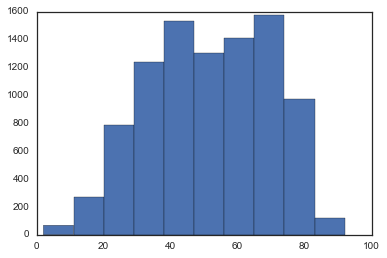

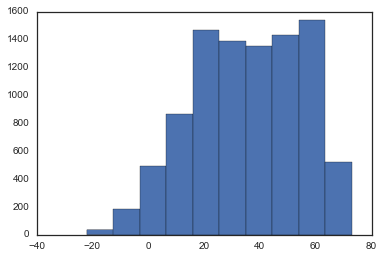

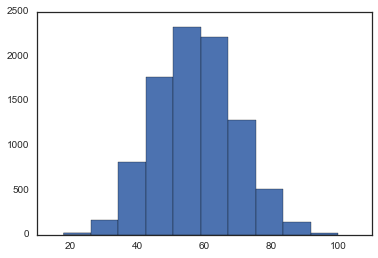

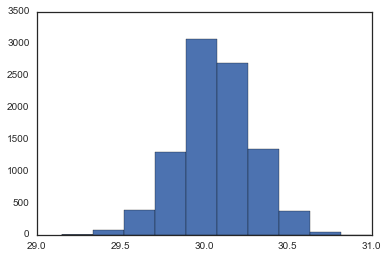

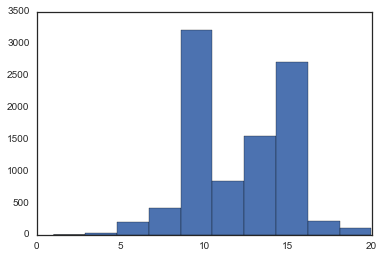

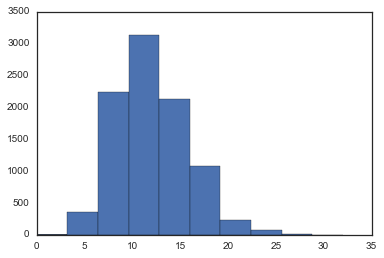

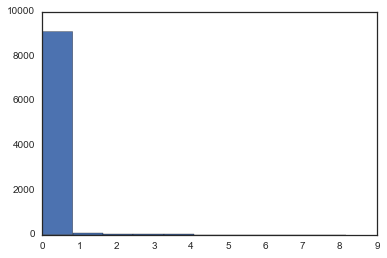

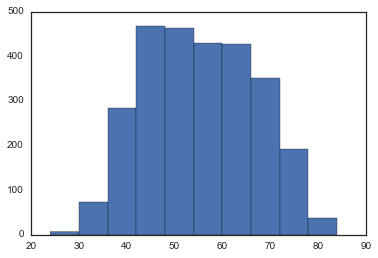

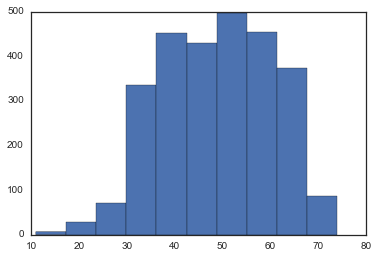

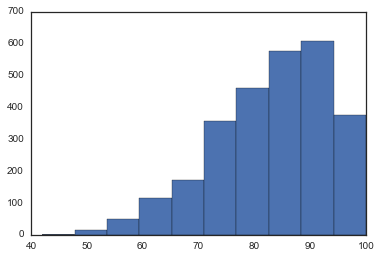

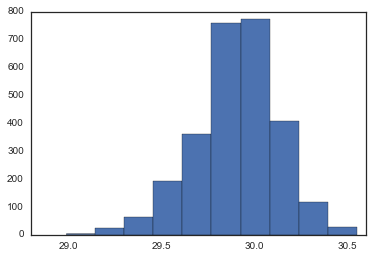

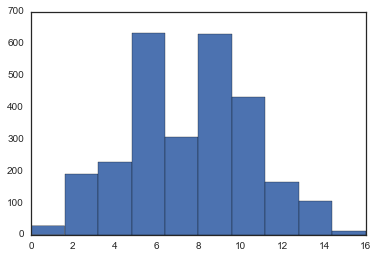

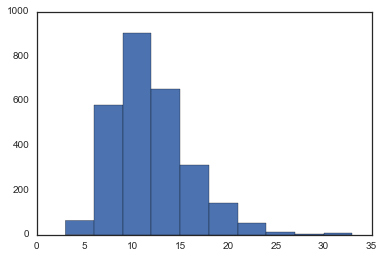

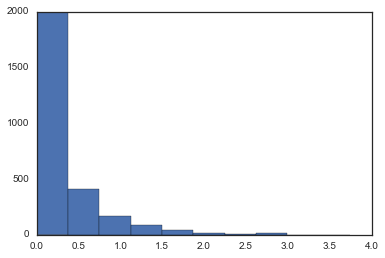

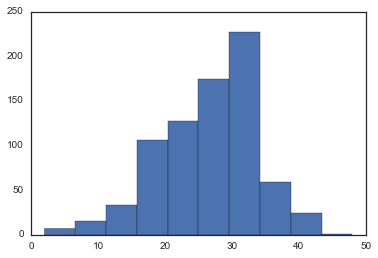

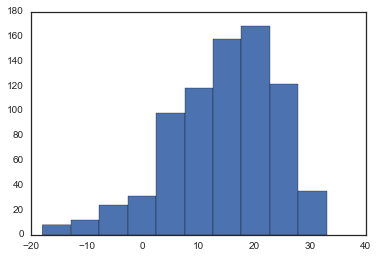

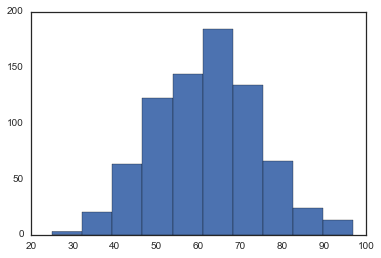

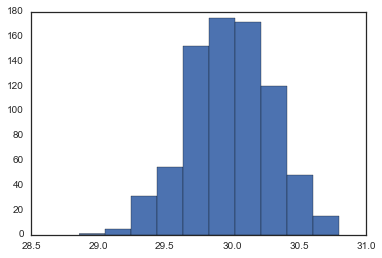

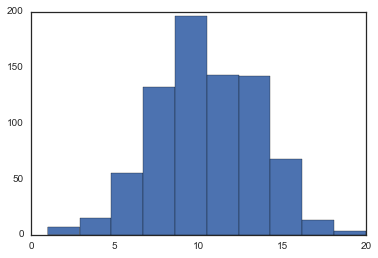

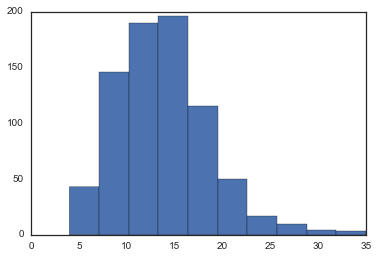

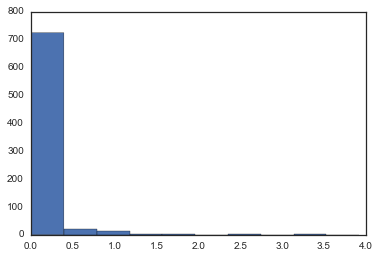

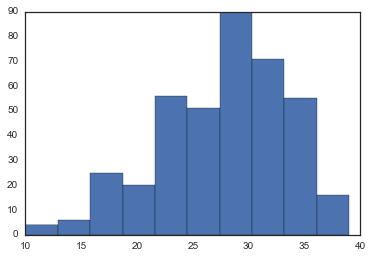

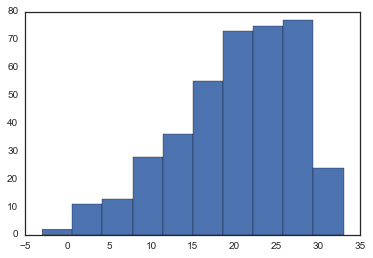

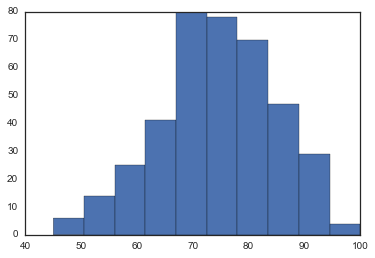

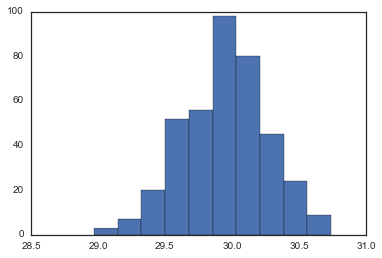

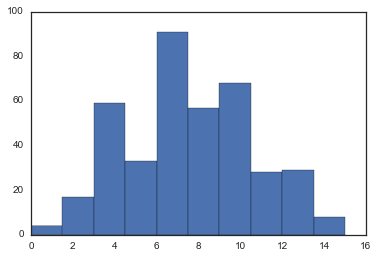

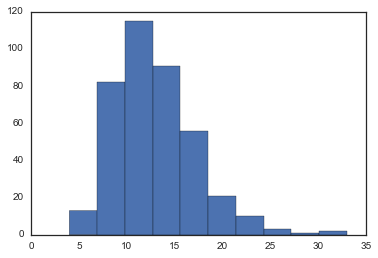

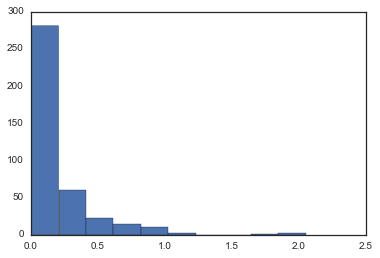

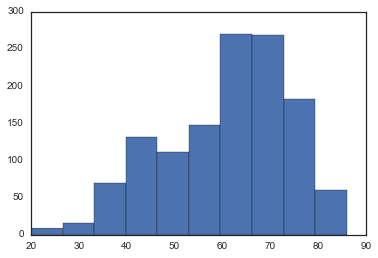

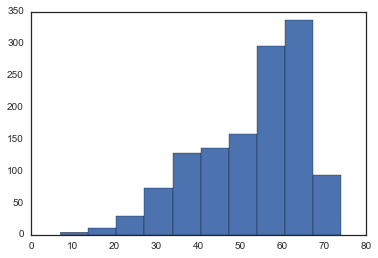

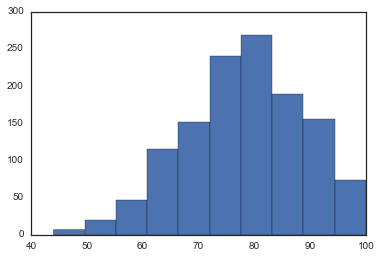

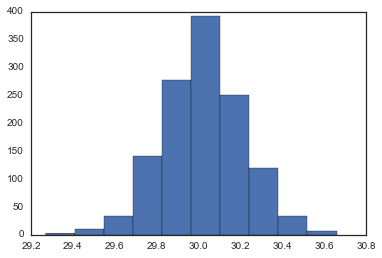

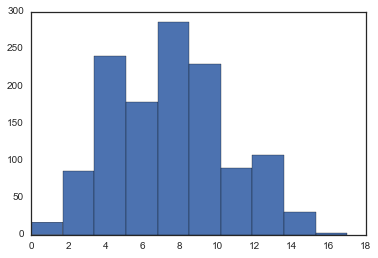

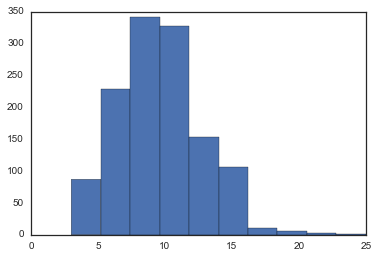

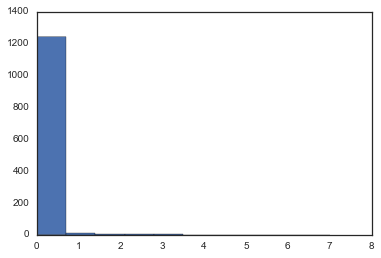

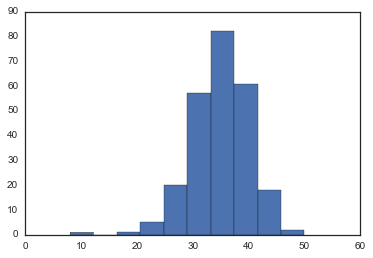

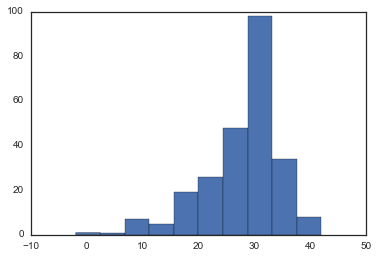

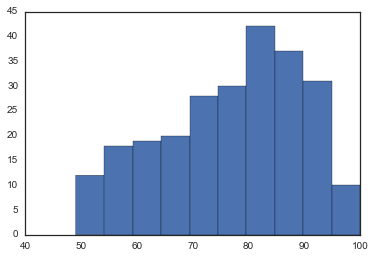

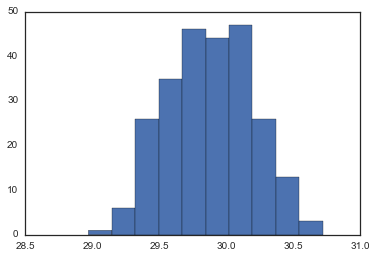

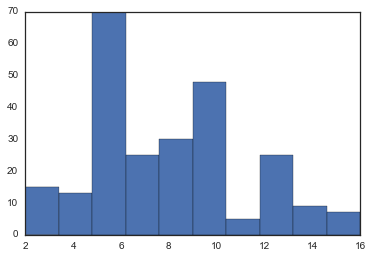

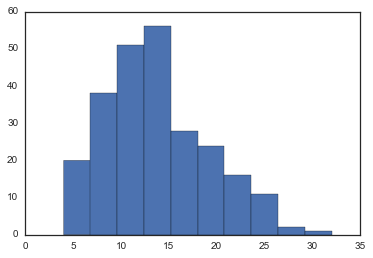

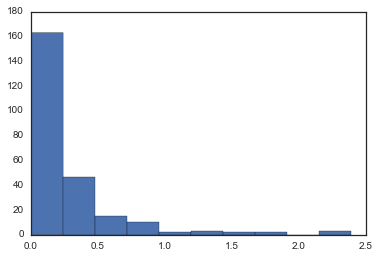

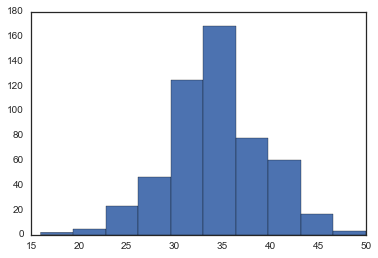

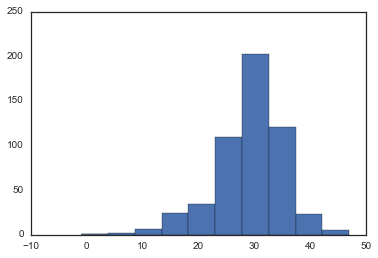

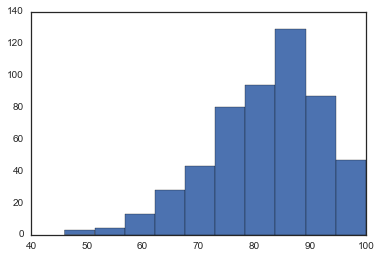

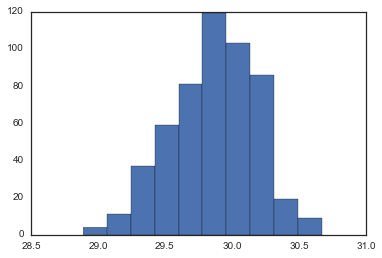

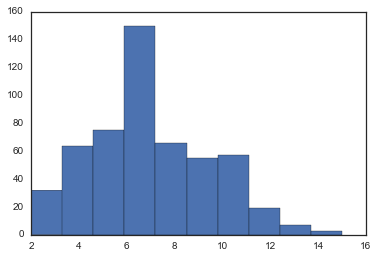

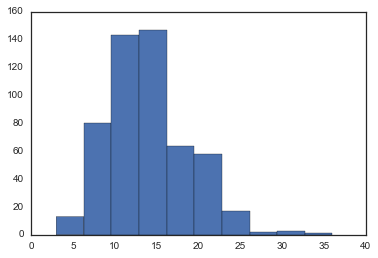

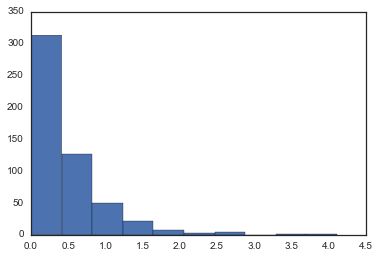

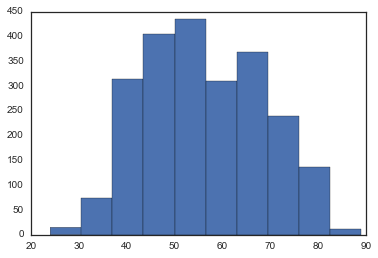

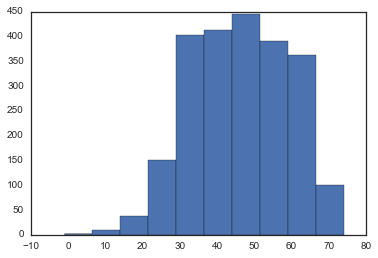

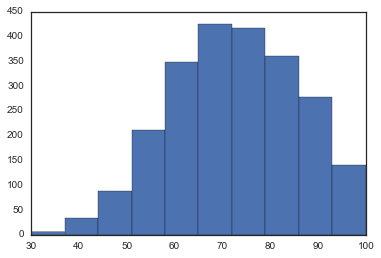

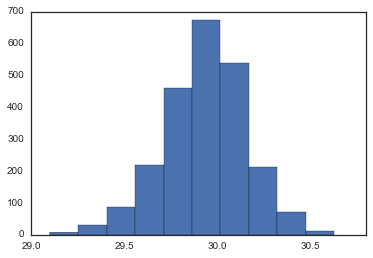

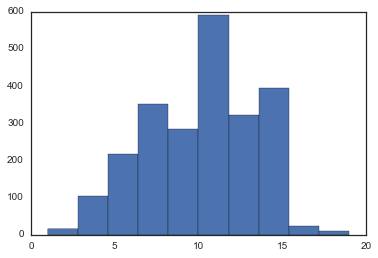

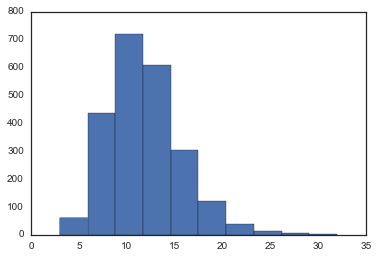

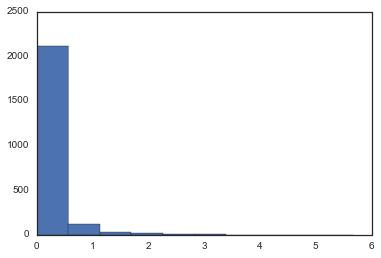

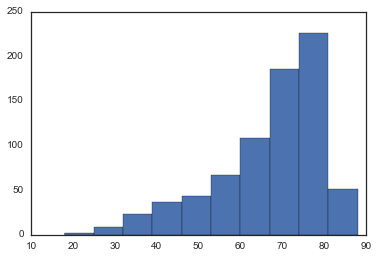

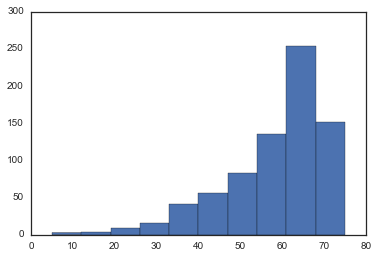

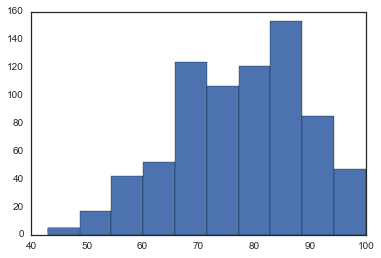

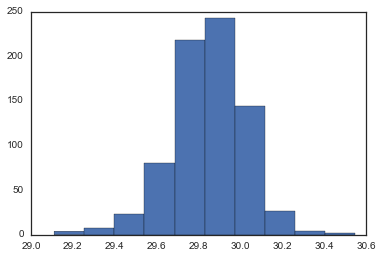

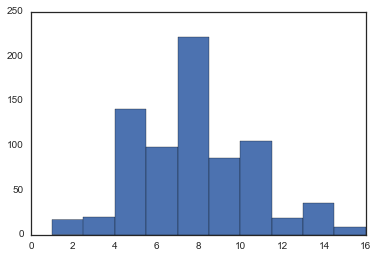

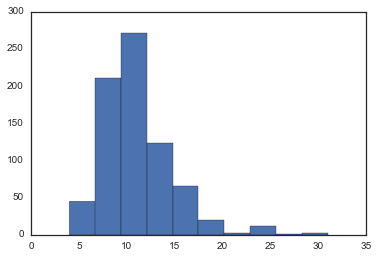

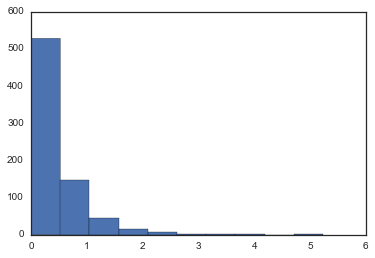

In [488]:
# Plot params across event types to confirm that a gaussian is a reasonable assumption
# Modeling precipitation alone as a lognormal as that makes more sense
for e in range(9):
    for i in range(7):
        if i == 6:
            #print(np.array(np.log(EP_data[e][params[i]])).mean())
            plt.hist(EP_data[e][params[i]])
            plt.show()
        else:
            plt.hist(EP_data[e][params[i]])
            plt.show()

In [455]:
# compute IP
# Initial prob
IP = np.zeros(no_distinct_events)
for i in range(no_distinct_events):
    IP[i] = 0.01/(no_distinct_events - 1)
IP[0] = 0.99 # Jan 1 2015 happens to be a noinfo day
print IP

[ 0.99     0.00125  0.00125  0.00125  0.00125  0.00125  0.00125  0.00125
  0.00125]


In [ ]:
list(df[" Events"].unique())

In [482]:
# Viterbi - second order HMM with log probabilities
def viterbi_log_second(IP, TP2, TP, EP, X):
    Z_inferred = np.empty(len(X)) #, dtype = "string")
    Z_state_ind = np.empty(len(X))
    T1 = np.zeros((9, 9, len(X)))
    T2 = np.zeros((9, 9, len(X)))
    IP_T1 = np.zeros(9)
    
    for i in range(9):
        IP_T1[i] = np.log10(IP[i]) + np.log10(compute_EP(np.array(X.iloc[0]), i))
        # T2[i, 0] = -1 

    for i in range(9):
        max_prob = float("-inf")
        for j in range(9):
            T1[j, i, 1] = IP_T1[j] + np.log10(TP[j, i]) + np.log10(compute_EP(np.array(X.iloc[1]), i))
            T2[j, i, 1] = -1
    
    for i in range(2, len(X)):
        if i%100 == 0:
            print i
        for j in range(9):
            for k in range(9):
                max_prob = float("-inf")
                ind = 0
                for l in range(9):
                    prob = T1[l, k, i-1] + np.log10(TP2[l, k, j]) \
                           + np.log10(compute_EP(np.array(X.iloc[i]), j))
                    #print prob
                    if max_prob < prob:
                        max_prob = prob
                        ind = l
                T1[k, j, i] = max_prob
                T2[k, j, i] = ind
            
    #print T1
#     print "hi"
#     print T2
    final_state_ind = np.argmax(T1[:, :, len(X) - 1])
    Z_state_ind[len(X) - 1] = final_state_ind%9
    Z_state_ind[len(X) - 2] = final_state_ind/9
    
    Z_inferred[len(X) - 1] = Z_state_ind[len(X) - 1] #convert_int_to_event(int(Z_state_ind[len(X) - 1]))
    Z_inferred[len(X) - 2] = Z_state_ind[len(X) - 2] #convert_int_to_event(int(Z_state_ind[len(X) - 2]))
    for i in reversed(range(2, len(X))):
        Z_state_ind[i-2] = int(T2[Z_state_ind[i-1], Z_state_ind[i], i])
        Z_inferred[i-2] = Z_state_ind[i-2] #convert_int_to_event(int(Z_state_ind[i-2]))
        
    Z_inferred_event = []
    for i in range(len(X)):
        Z_inferred_event.append(convert_int_to_event(int(Z_inferred[i])))
    return Z_inferred_event

In [476]:
df_2015 = ds.fetch_data("KBOS", date(2011, 1, 1), date(2011, 12, 31))

In [477]:
replace_NaNs(df_2015)

In [483]:
EP = []
l = 30
Z_inferred = viterbi_log_second(IP, TP2, TP, EP, df_2015[params])

100
200
300


/Users/vinaysubbiah/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [472]:
def evaluation(inferred, original, specific_target=None):
    assert len(inferred) == len(original)
    mistake_count = 0
    total_count = 0
    for i in range(len(original)):
        if specific_target is None:
            total_count += 1
            if inferred[i] != original[i] and (inferred[i] != "Thunderstorm" or original[i].find("Thunderstorm") == -1):
                mistake_count += 1
        else:
            if original[i] == specific_target or \
              (specific_target == "Thunderstorm" and original[i].find(specific_target) != -1):
                total_count += 1
                if inferred[i] != original[i] and (inferred[i] != "Thunderstorm" or original[i].find("Thunderstorm") == -1):
                    mistake_count += 1
                
    percentage_accurate = 1 - mistake_count/float(total_count)
    return mistake_count, total_count, percentage_accurate

In [423]:
print Z_inferred[105]

Thunderstorm


In [ ]:
count = 0
for i in range(len(Z_inferred)):
    if Z_inferred[i].find("Thunderstorm") != -1:
        print i
        count +=1
print count

In [484]:
original = list(df_2015[" Events"])
#print original
print len(original)

324


In [485]:
print(evaluation(Z_inferred[0:4000], original))

(130, 324, 0.5987654320987654)


In [473]:
targets = ['noinfo',
 'Fog-Rain',
 'Snow',
 'Fog-Snow',
 'Fog',
 'Rain-Snow',
 'Fog-Rain-Snow',
 'Rain',
 "Thunderstorm"]
for target in targets:
    print target
    print(evaluation(Z_inferred[0:4000], original, specific_target=target))

noinfo
(175, 936, 0.813034188034188)
Fog-Rain
(27, 56, 0.5178571428571428)
Snow
(30, 49, 0.3877551020408163)
Fog-Snow
(10, 30, 0.6666666666666667)
Fog
(6, 27, 0.7777777777777778)
Rain-Snow
(42, 56, 0.25)
Fog-Rain-Snow
(11, 17, 0.3529411764705882)
Rain
(250, 362, 0.30939226519337015)
Thunderstorm
(21, 59, 0.6440677966101696)


In [469]:
# construct confusion matrix
def conf_mat(inferred, original):
    conf_mat = np.zeros((9, 9))
    assert len(inferred) == len(original)
    mistake_count = 0
    total_count = 0
    for i in range(len(original)):
        conf_mat[convert_event_to_int(original[i]), convert_event_to_int(inferred[i])] += 1
    return conf_mat

In [470]:
conf_mat = conf_mat(Z_inferred[0:4000], original)
print conf_mat

[[ 761.    3.   63.    1.   84.   11.    0.   11.    2.]
 [   1.   29.    0.    0.    9.    2.    3.    7.    5.]
 [   6.    0.   19.   18.    0.    3.    2.    1.    0.]
 [   0.    0.    3.   20.    0.    2.    5.    0.    0.]
 [   6.    0.    0.    0.   21.    0.    0.    0.    0.]
 [   1.    0.    1.    9.    0.   14.   22.    9.    0.]
 [   0.    0.    0.    5.    0.    6.    6.    0.    0.]
 [  45.  109.    4.    0.   10.   18.    9.  112.   55.]
 [   4.    9.    0.    0.    2.    1.    0.    5.   38.]]


In [320]:
list(df[" Events"].unique())

['noinfo',
 'Fog-Rain',
 'Snow',
 'Fog-Snow',
 'Fog',
 'Rain-Snow',
 'Fog-Rain-Snow',
 'Rain',
 'Fog-Rain-Thunderstorm',
 'Fog-Rain-Snow-Thunderstorm',
 'Rain-Thunderstorm',
 'Rain-Snow-Thunderstorm',
 'Fog-Snow-Thunderstorm',
 'Thunderstorm',
 'Fog-Thunderstorm',
 'Fog-Rain-Snow-Hail-Thunderstorm',
 'Fog-Rain-Hail-Thunderstorm',
 'Tornado',
 'Rain-Hail-Thunderstorm']

### HMM Third Order Model

In [471]:
def normalize_4d(matrix):
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            for k in range(matrix.shape[2]):
                matrix[i, j, k] = matrix[i, j, k]/float(sum(matrix[i, j, k]))
    return matrix

In [467]:
# constructing TP3

TP3 = np.ones((no_distinct_events, no_distinct_events, no_distinct_events, no_distinct_events))

for i in range(len(df) - 3):        
    state_i_minus_2 = convert_event_to_int(df.iloc[i][" Events"])
    state_i_minus_1 = convert_event_to_int(df.iloc[i+1][" Events"])
    state_i = convert_event_to_int(df.iloc[i+2][" Events"])
    to_state = convert_event_to_int(df.iloc[i+3][" Events"])
    TP3[state_i_minus_1, state_i, to_state] += 1

TP3 = normalize_4d(TP3)

In [ ]:
# Viterbi - third order HMM with log probabilities
def viterbi_log_third(IP, TP3, TP2, TP, EP, X):
    Z_inferred = np.empty(len(X)) #, dtype = "string")
    Z_state_ind = np.empty(len(X))
    T1 = np.zeros((9, 9, 9, len(X)))
    T2 = np.zeros((9, 9, 9, len(X)))
    IP_T1 = np.zeros(9)
    IP_T2 = np.zeros((9, 9))
    
    for i in range(9):
        IP_T1[i] = np.log10(IP[i]) + np.log10(compute_EP(np.array(X.iloc[0]), i))
        # T2[i, 0] = -1 

    for i in range(9):
        for j in range(9):
            IP_T2[j, i] = IP_T1[j] + np.log10(TP[j, i]) + np.log10(compute_EP(np.array(X.iloc[1]), i))
            
    for i in range(9):
        # max_prob = float("-inf")
        for j in range(9):
            T1[j, i, 1] = IP_T1[j] + np.log10(TP[j, i]) + np.log10(compute_EP(np.array(X.iloc[1]), i))
            T2[j, i, 1] = -1
    
    
        
    
    for i in range(3, len(X)):
        if i%100 == 0:
            print i
        for j in range(9):
            for k in range(9):
                for k1 in range(9):
                    max_prob = float("-inf")
                    ind = 0
                    for l in range(9):
                        prob = T1[l, k1, k, i-1] + np.log10(TP3[l, k1, k, j]) \
                               + np.log10(compute_EP(np.array(X.iloc[i]), j))
                        #print prob
                        if max_prob < prob:
                            max_prob = prob
                            ind = l
                    T1[k, j, i] = max_prob
                    T2[k, j, i] = ind
            
    #print T1
#     print "hi"
#     print T2
    final_state_ind = np.argmax(T1[:, :, len(X) - 1])
    Z_state_ind[len(X) - 1] = final_state_ind%9
    Z_state_ind[len(X) - 2] = final_state_ind/9
    
    Z_inferred[len(X) - 1] = Z_state_ind[len(X) - 1] #convert_int_to_event(int(Z_state_ind[len(X) - 1]))
    Z_inferred[len(X) - 2] = Z_state_ind[len(X) - 2] #convert_int_to_event(int(Z_state_ind[len(X) - 2]))
    for i in reversed(range(2, len(X))):
        Z_state_ind[i-2] = int(T2[Z_state_ind[i-1], Z_state_ind[i], i])
        Z_inferred[i-2] = Z_state_ind[i-2] #convert_int_to_event(int(Z_state_ind[i-2]))
        
    Z_inferred_event = []
    for i in range(len(X)):
        Z_inferred_event.append(convert_int_to_event(int(Z_inferred[i])))
    return Z_inferred_event
